# 02. Résultats Finaux & Interprétabilité
**Projet KDD - Decision Stump C5.0**

Présentation détaillée du modèle final : règle découverte, matrice de confusion et frontière de décision.
---

In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ajout du dossier parent au chemin pour importer 'src'
sys.path.append(os.path.abspath('..'))

# Configuration graphique
%matplotlib inline
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Environnement chargé.")

✅ Environnement chargé.


In [2]:
from src.stump import DecisionStump
from src.metrics import accuracy, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Data setup
try:
    df = pd.read_csv('../data/raw/iris.csv')
except:
    from sklearn.datasets import load_iris
    d = load_iris(); df = pd.DataFrame(d.data, columns=d.feature_names); df['target'] = d.target

X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values
features = df.columns[:-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## 1. La Règle d'Or (The Golden Rule)
Quel est l'attribut le plus discriminant selon le Gain Ratio ?

In [3]:
model = DecisionStump(criterion='gain_ratio')
model.fit(X_train, y_train, feature_names=features)

if model.feature_index_ is not None:
    print(f"✨ Feature Séparatrice : {model.feature_name_}")
    print(f"✨ Seuil de coupure    : <= {model.threshold_:.3f}")
    print(f"✨ Gain de la règle    : {model.feature_type_}") # feature_type stocke 'numerical' ici
else:
    print("Modèle constant.")

✨ Feature Séparatrice : petal length (cm)
✨ Seuil de coupure    : <= 2.450
✨ Gain de la règle    : numerical


C:\Users\halim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## 2. Analyse des Erreurs (Matrice de Confusion)

C:\Users\halim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


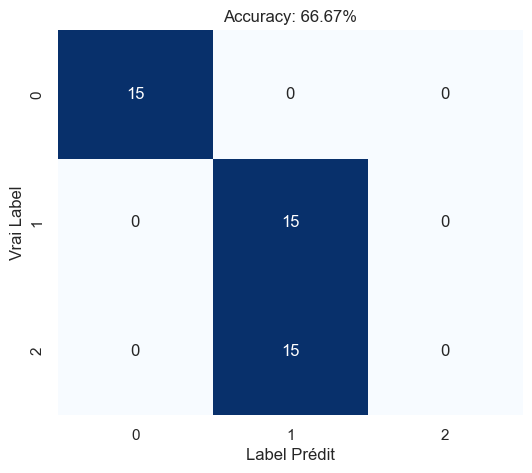

In [4]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.ylabel('Vrai Label')
plt.xlabel('Label Prédit')
plt.title(f"Accuracy: {accuracy(y_test, y_pred):.2%}")
plt.show()

## 3. Visualisation de la Frontière de Décision
Projection 2D sur les deux meilleures features.

C:\Users\halim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\halim\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


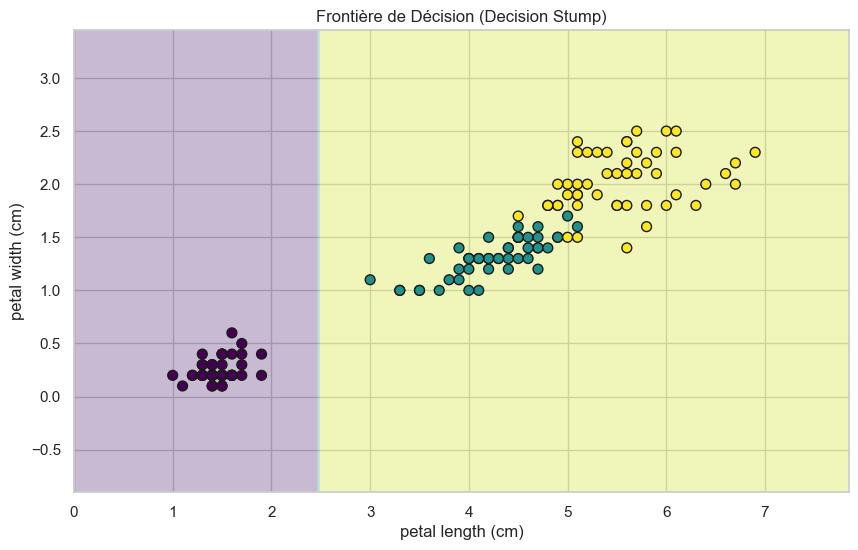

In [5]:
def plot_boundary(X, y, feat_idx_1, feat_idx_2, features):
    # Subset 2 features
    X_sub = X[:, [feat_idx_1, feat_idx_2]]
    
    # Re-train simple stump
    clf = DecisionStump(criterion='gain_ratio')
    clf.fit(X_sub, y)
    
    # Grid
    x_min, x_max = X_sub[:, 0].min() - 1, X_sub[:, 0].max() + 1
    y_min, y_max = X_sub[:, 1].min() - 1, X_sub[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05),
                         np.arange(y_min, y_max, 0.05))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.scatter(X_sub[:, 0], X_sub[:, 1], c=y, s=50, edgecolor='k', cmap='viridis')
    plt.xlabel(features[feat_idx_1])
    plt.ylabel(features[feat_idx_2])
    plt.title("Frontière de Décision (Decision Stump)")
    plt.show()

# On prend généralement Longueur et Largeur Pétale (indices 2 et 3)
plot_boundary(X, y, 2, 3, features)